In [79]:
import pandas as pd
import numpy as np
from preprocessing import d_norm, i_norm
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
pd.set_option('display.max_columns', 20)
df = pd.read_excel("./data/data_merged_new.xlsx", index_col=0)
df.set_index("IDcard", inplace=True)
df.head(5)

,AGE,SEX,GROUP,PARKINSON,STAGE,PD_duration (years),курение,АГ,СД,ХПН,...,803.694275,805.66482,807.635943,809.607641,811.579916,813.552766,815.526191,817.500191,819.474764,821.44991
IDcard,,,,,,,,,,,,,,,,,,,,,
CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,NaN,...,41,34,28,38,29,35,37,33,29,29
CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,NaN,...,32,33,31,39,25,30,21,16,31,22
CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,NaN,...,21,24,25,28,32,23,16,23,20,19
CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,NaN,...,33,18,22,25,18,17,36,22,24,25
CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,NaN,...,27,22,16,19,15,21,24,30,22,21


Предобработка

In [ ]:
pd.set_option('display.max_columns', 20)
df = pd.read_excel("./data/data_merged_new.xlsx", index_col=0)
df.set_index("IDcard", inplace=True)

group = []
for x in df.loc["БП008(Л)":].index:
    if "БП" in x:
        group.append("Parkinson")
    else:
        group.append("Control")
group = df.dropna(subset=["GROUP"])["GROUP"].to_list() + group
df["GROUP"] = group
df.reset_index(inplace=True)
df["level_3"] =  [x + f"_{i % 8 + 1}" for i, x in enumerate(df["IDcard"])]
df.set_index(["GROUP", "IDcard", "level_3"], inplace=True)
df = df.loc[:, 401.733364293274:]

df = d_norm(df)
df = df.merge(i_norm(df), right_index=True, left_index=True)

Разделение на выборки

In [85]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

idx = pd.IndexSlice
X = df.loc[:, "D401":"D676"].copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df.index.get_level_values("GROUP").to_list()], index = df.index)
y_buf = y.groupby(level=1).max()
y_train, y_val = train_test_split(y_buf, stratify=y_buf, test_size=0.2, random_state=33)
X_train = X.loc[idx[:, y_train.index, :]]
X_val = X.loc[idx[:, y_val.index, :]]
y_train = y.loc[idx[:, y_train.index, :]]
y_val = y.loc[idx[:, y_val.index, :]]

<Axes: ylabel='Count'>

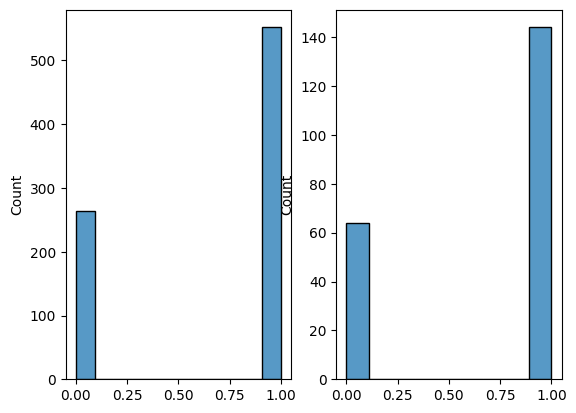

In [87]:
fig, ax = plt.subplots(1, 2)
sns.histplot(y_train, ax=ax[0])
sns.histplot(y_val, ax=ax[1])

Обучение

In [88]:
clf = SVC(class_weight="balanced", probability=True)
clf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [90]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

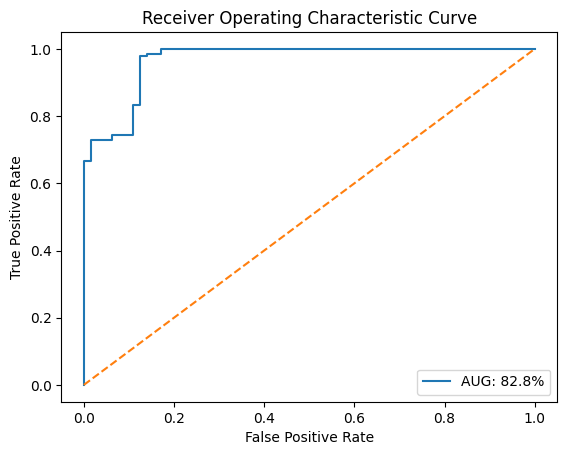

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
def draw_infograph(clf, y_true, proba, y_pred):
    score = roc_auc_score(y_true, y_pred)
    fpr, tpr, _= roc_curve(y_true, proba, pos_label=1)

    plt.plot(fpr, tpr)
    plt.plot ([0, 1], [0, 1], linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend([f"AUG: {score * 100 :.1f}%"])

y_pred = clf.predict(X_val)
proba = clf.predict_proba(X_val)[:, 1]
draw_infograph(clf, y_val, proba, y_pred)